# An Introduction to SageMaker ObjectToVec model for MovieLens recommendation
### MD: modified to work on a local container


1. [Background](#Background)
1. [Data exploration and preparation](#Data-exploration-and-preparation)
1. [Rating prediction task](#Rating-prediction-task)
1. [Recommendation task](#Recommendation-task)
1. [Movie retrieval in the embedding space](#Movie-retrieval-in-the-embedding-space)

# Background

### ObjectToVec
*Object2Vec* is a highly customizable multi-purpose algorithm that can learn embeddings of pairs of objects. The embeddings are learned such that it preserves their pairwise **similarities** in the original space.
- **Similarity** is user-defined: users need to provide the algorithm with pairs of objects that they define as similar (1) or dissimilar (0); alternatively, the users can define similarity in a continuous sense (provide a real-valued similarity score)
- The learned embeddings can be used to efficiently compute nearest neighbors of objects, as well as to visualize natural clusters of related objects in the embedding space. In addition, the embeddings can also be used as features of the corresponding objects in downstream supervised tasks such as classification or regression

## In this notebook example:
We demonstrate how Object2Vec can be used to solve problems arising in recommendation systems. Specifically,

- We provide the algorithm with (UserID, MovieID) pairs; for each such pair, we also provide a "label" that tells the algorithm whether the user and movie are similar or not

     * When the labels are real-valued, we use the algorithm to predict the exact ratings of a movie given a user
     * When the labels are binary, we use the algorithm to recommendation movies to users

- The diagram below shows the customization of our model to the problem of predicting movie ratings, using a dataset that provides `(UserID, ItemID, Rating)` samples. Here, ratings are real-valued

<img style="float:middle" src="image_ml_rating.png" width="480">

### Dataset
- We use the MovieLens 100k dataset: https://grouplens.org/datasets/movielens/100k/

### Use cases

- Task 1: Rating prediction (regression)
- Task 2: Movie recommendation (classification)
- Task 3: Nearest-neighbor movie retrieval in the learned embedding space

### Before running the notebook
- Please use a Python 3 kernel for the notebook
- Please make sure you have `jsonlines` package installed (if not, you can run the command below to install it)

In [43]:
# md: it is already installed on conda python3

# !pip install jsonlines

In [2]:
import sys
# ! {sys.prefix}/bin/pip install jsonlines

In [45]:
# ! {sys.prefix}/bin/pip install pandas

In [46]:
# ! {sys.prefix}/bin/pip install --upgrade jupyter_contrib_nbextensions

In [47]:
# ! jupyter contrib nbextension install --sys-prefix

In [48]:
# ! conda upgrade jupyter_contrib_nbextensions

In [3]:
import os
import sys
import csv, jsonlines
import numpy as np
import copy
import random

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Data exploration and preparation

### License
Please be aware of the following requirements about ackonwledgment, copyright and availability, cited from the [data set description page](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).
>The data set may be used for any research
purposes under the following conditions:
     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.
     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).
     * The user may not redistribute the data without separate
       permission.
     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a faculty member of the GroupLens Research Project at the
       University of Minnesota.
If you have any further questions or comments, please contact GroupLens \<grouplens-info@cs.umn.edu\>. 

In [51]:
# %%bash

# curl -o ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
# unzip ml-100k.zip
# rm ml-100k.zip

Let's first create some utility functions for data exploration and preprocessing

In [5]:
## some utility functions

def load_csv_data(filename, delimiter, verbose=True):
    """
    input: a file readable as csv and separated by a delimiter
    and has format users - movies - ratings - etc
    output: a list, where each row of the list is of the form
    {'in0':userID, 'in1':movieID, 'label':rating}
    """
    to_data_list = list()
    users = list()
    movies = list()
    ratings = list()
    unique_users = set()
    unique_movies = set()
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        for count, row in enumerate(reader):
            #if count!=0:
            to_data_list.append({'in0':[int(row[0])], 'in1':[int(row[1])], 'label':float(row[2])})
            users.append(row[0])
            movies.append(row[1])
            ratings.append(float(row[2]))
            unique_users.add(row[0])
            unique_movies.add(row[1])
    if verbose:
        print("In file {}, there are {} ratings".format(filename, len(ratings)))
        print("The ratings have mean: {}, median: {}, and variance: {}".format(
                                            round(np.mean(ratings), 2), 
                                            round(np.median(ratings), 2), 
                                            round(np.var(ratings), 2)))
        print("There are {} unique users and {} unique movies".format(len(unique_users), len(unique_movies)))
    return to_data_list


def csv_to_augmented_data_dict(filename, delimiter):
    """
    Input: a file that must be readable as csv and separated by delimiter (to make columns)
    has format users - movies - ratings - etc
    Output:
      Users dictionary: keys as user ID's; each key corresponds to a list of movie ratings by that user
      Movies dictionary: keys as movie ID's; each key corresponds a list of ratings of that movie by different users
    """
    to_users_dict = dict() 
    to_movies_dict = dict()
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        for count, row in enumerate(reader):
            #if count!=0:
            if row[0] not in to_users_dict:
                to_users_dict[row[0]] = [(row[1], row[2])]
            else:
                to_users_dict[row[0]].append((row[1], row[2]))
            if row[1] not in to_movies_dict:
                to_movies_dict[row[1]] = list(row[0])
            else:
                to_movies_dict[row[1]].append(row[0])
    return to_users_dict, to_movies_dict


def user_dict_to_data_list(user_dict):
    # turn user_dict format to data list format (acceptable to the algorithm)
    data_list = list()
    for user, movie_rating_list in user_dict.items():
        for movie, rating in movie_rating_list:
            data_list.append({'in0':[int(user)], 'in1':[int(movie)], 'label':float(rating)})
    return data_list

def divide_user_dicts(user_dict, sp_ratio_dict):
    """
    Input: A user dictionary, a ration dictionary
         - format of sp_ratio_dict = {'train':0.8, "test":0.2}
    Output: 
        A dictionary of dictionaries, with key corresponding to key provided by sp_ratio_dict
        and each key corresponds to a subdivded user dictionary
    """
    ratios = [val for _, val in sp_ratio_dict.items()]
    assert np.sum(ratios) == 1, "the sampling ratios must sum to 1!"
    divided_dict = {}
    for user, movie_rating_list in user_dict.items():
        sub_movies_ptr = 0
        sub_movies_list = []
        #movie_list, _ = zip(*movie_rating_list)
        #print(movie_list)
        for i, ratio in enumerate(ratios):
            if i < len(ratios)-1:
                sub_movies_ptr_end = sub_movies_ptr + int(len(movie_rating_list)*ratio)
                sub_movies_list.append(movie_rating_list[sub_movies_ptr:sub_movies_ptr_end])
                sub_movies_ptr = sub_movies_ptr_end
            else:
                sub_movies_list.append(movie_rating_list[sub_movies_ptr:])
        for subset_name in sp_ratio_dict.keys():
            if subset_name not in divided_dict:
                divided_dict[subset_name] = {user: sub_movies_list.pop(0)}
            else:
                #access sub-dictionary
                divided_dict[subset_name][user] = sub_movies_list.pop(0)
    
    return divided_dict

def write_csv_to_jsonl(jsonl_fname, csv_fname, csv_delimiter):
    """
    Input: a file readable as csv and separated by delimiter (to make columns)
        - has format users - movies - ratings - etc
    Output: a jsonline file converted from the csv file
    """
    with jsonlines.open(jsonl_fname, mode='w') as writer:
        with open(csv_fname, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=csv_delimiter)
            for count, row in enumerate(reader):
                #print(row)
                #if count!=0:
                writer.write({'in0':[int(row[0])], 'in1':[int(row[1])], 'label':float(row[2])})
        print('Created {} jsonline file'.format(jsonl_fname))
                    
    
def write_data_list_to_jsonl(data_list, to_fname):
    """
    Input: a data list, where each row of the list is a Python dictionary taking form
    {'in0':userID, 'in1':movieID, 'label':rating}
    Output: save the list as a jsonline file
    """
    with jsonlines.open(to_fname, mode='w') as writer:
        for row in data_list:
            #print(row)
            writer.write({'in0':row['in0'], 'in1':row['in1'], 'label':row['label']})
    print("Created {} jsonline file".format(to_fname))

def data_list_to_inference_format(data_list, binarize=True, label_thres=3):
    """
    Input: a data list
    Output: test data and label, acceptable by SageMaker for inference
    """
    data_ = [({"in0":row['in0'], 'in1':row['in1']}, row['label']) for row in data_list]
    data, label = zip(*data_)
    infer_data = {"instances":data}
    if binarize:
        label = get_binarized_label(list(label), label_thres)
    return infer_data, label


def get_binarized_label(data_list, thres):
    """
    Input: data list
    Output: a binarized data list for recommendation task
    MD: replace the labels that are curently 1 to 5 values , to 
    """
    for i, row in enumerate(data_list):
        if type(row) is dict:
            #if i < 10:
                #print(row['label'])
            if row['label'] > thres:
                #print(row)
                data_list[i]['label'] = 1
            else:
                data_list[i]['label'] = 0
        else:
            if row > thres:
                data_list[i] = 1
            else:
                data_list[i] = 0
    return data_list


In [6]:
## Load data and shuffle
prefix = 'ml-100k'
train_path = os.path.join(prefix, 'ua.base')
valid_path = os.path.join(prefix, 'ua.test')
test_path = os.path.join(prefix, 'ub.test')
print(train_path)
print(test_path)

ml-100k/ua.base
ml-100k/ub.test


In [54]:
train_data_list = load_csv_data(train_path, '\t')
random.shuffle(train_data_list)

validation_data_list = load_csv_data(valid_path, '\t')
random.shuffle(validation_data_list)


In file ml-100k/ua.base, there are 90570 ratings
The ratings have mean: 3.52, median: 4.0, and variance: 1.27
There are 943 unique users and 1680 unique movies
In file ml-100k/ua.test, there are 9430 ratings
The ratings have mean: 3.59, median: 4.0, and variance: 1.25
There are 943 unique users and 1129 unique movies


In [55]:
print(type(train_data_list))
print(train_data_list[:3])

<class 'list'>
[{'in0': [100], 'in1': [315], 'label': 5.0}, {'in0': [314], 'in1': [1094], 'label': 1.0}, {'in0': [59], 'in1': [484], 'label': 4.0}]


In [56]:
print(validation_data_list[:3])

[{'in0': [281], 'in1': [332], 'label': 4.0}, {'in0': [184], 'in1': [412], 'label': 2.0}, {'in0': [507], 'in1': [338], 'label': 5.0}]


In [57]:
to_users_dict, to_movies_dict = csv_to_augmented_data_dict(train_path, '\t')

In [58]:
print(to_users_dict[list(to_users_dict.keys())[0]])

[('1', '5'), ('2', '3'), ('3', '4'), ('4', '3'), ('5', '3'), ('6', '5'), ('7', '4'), ('8', '1'), ('9', '5'), ('10', '3'), ('11', '2'), ('12', '5'), ('13', '5'), ('14', '5'), ('15', '5'), ('16', '5'), ('17', '3'), ('18', '4'), ('19', '5'), ('21', '1'), ('22', '4'), ('23', '4'), ('24', '3'), ('25', '4'), ('26', '3'), ('27', '2'), ('28', '4'), ('29', '1'), ('30', '3'), ('31', '3'), ('32', '5'), ('34', '2'), ('35', '1'), ('36', '2'), ('37', '2'), ('38', '3'), ('39', '4'), ('40', '3'), ('41', '2'), ('42', '5'), ('43', '4'), ('44', '5'), ('45', '5'), ('46', '4'), ('47', '4'), ('48', '5'), ('49', '3'), ('50', '5'), ('51', '4'), ('52', '4'), ('53', '3'), ('54', '3'), ('55', '5'), ('56', '4'), ('57', '5'), ('58', '4'), ('59', '5'), ('60', '5'), ('62', '3'), ('63', '2'), ('64', '5'), ('65', '4'), ('66', '4'), ('67', '3'), ('68', '4'), ('69', '3'), ('70', '3'), ('71', '3'), ('72', '4'), ('73', '3'), ('74', '1'), ('75', '4'), ('76', '4'), ('77', '4'), ('78', '1'), ('79', '4'), ('80', '4'), ('81', 

In [59]:
to_movies_dict[list(to_movies_dict.keys())[0]][:3]


['1', '2', '6']

### We perform some data exploration

In [60]:
## Calculate min, max, median of number of movies per user
movies_per_user = [len(val) for key, val in to_users_dict.items()]
len(movies_per_user)

943

In [61]:
print("The min, max, and median 'movies per user' is {}, {}, and {}".format(
    np.amin(movies_per_user),
    np.amax(movies_per_user),
    np.median(movies_per_user)
))


The min, max, and median 'movies per user' is 10, 727, and 55.0


In [62]:
users_per_movie = [len(val) for key, val in to_movies_dict.items()]
users_per_movie[:3]
len(users_per_movie)

1680

In [63]:
print("The min, max, and median 'users per movie' is {}, {}, and {}".format(
    np.amin(users_per_movie),
    np.amax(users_per_movie),
    np.median(users_per_movie)
))

The min, max, and median 'users per movie' is 1, 495, and 25.0


In [64]:
count = 0
n_movies_lower_bound = 20
for n_movies in movies_per_user:
    if n_movies <= n_movies_lower_bound:
        count += 1
print("In the training set")
print('There are {} users with no more than {} movies'.format(count, n_movies_lower_bound))

In the training set
There are 213 users with no more than 20 movies


In [65]:
#
count = 0
n_users_lower_bound = 2
for n_users in users_per_movie:
    if n_users <= n_users_lower_bound:
        count += 1
print('There are {} movies with no more than {} user'.format(count, n_users_lower_bound))

There are 12 movies with no more than 2 user


Text(0.5, 1.0, 'Movies per user')

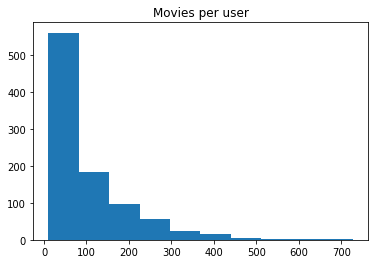

In [66]:
## figures

f = plt.figure(1)
plt.hist(movies_per_user)
plt.title("Movies per user")

Text(0.5, 1.0, 'Users per movie')

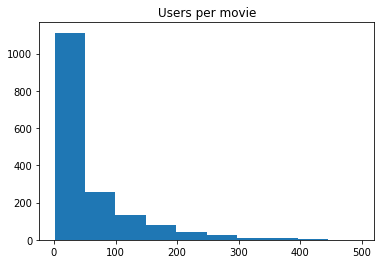

In [67]:
##
g = plt.figure(2)
plt.hist(users_per_movie)
plt.title("Users per movie")

Since the number of movies with an extremely small number of users (<3) is negligible compared to the total number of movies, we will not remove movies from the data set (same applies for users) 

## Save training and validation data locally for rating-prediction (regression) task

In [68]:
write_data_list_to_jsonl(copy.deepcopy(train_data_list), 'train_r.jsonl')
write_data_list_to_jsonl(copy.deepcopy(validation_data_list), 'validation_r.jsonl')

Created train_r.jsonl jsonline file
Created validation_r.jsonl jsonline file


## Save training and validation data locally for recommendation (classification) task

### binarize the data 

In [69]:
train_c = get_binarized_label(copy.deepcopy(train_data_list), 3.0)
valid_c = get_binarized_label(copy.deepcopy(validation_data_list), 3.0)

In [70]:
write_data_list_to_jsonl(train_c, 'train_c.jsonl')
write_data_list_to_jsonl(valid_c, 'validation_c.jsonl')

Created train_c.jsonl jsonline file
Created validation_c.jsonl jsonline file


**We check whether the two classes are balanced after binarization**

In [71]:
train_c_label = [row['label'] for row in train_c]
valid_c_label = [row['label'] for row in valid_c]

In [72]:
print("There are {} fraction of positive ratings in train_c.jsonl".format(
                                np.count_nonzero(train_c_label)/len(train_c_label)))
print("There are {} fraction of positive ratings in validation_c.jsonl".format(
                                np.sum(valid_c_label)/len(valid_c_label)))

There are 0.5510213094843768 fraction of positive ratings in train_c.jsonl
There are 0.5799575821845175 fraction of positive ratings in validation_c.jsonl


# Rating prediction task 

In [73]:
def get_mse_loss(res, labels):
    if type(res) is dict:
        res = res['predictions']
    assert len(res)==len(labels), 'result and label length mismatch!'
    loss = 0
    for row, label in zip(res, labels):
        if type(row) is dict:
            loss += (row['scores'][0]-label)**2
        else:
            loss += (row-label)**2
    return round(loss/float(len(labels)), 2)

In [74]:
valid_r_data, valid_r_label = data_list_to_inference_format(copy.deepcopy(validation_data_list), binarize=False)

#### We first test the problem on two baseline algorithms

## Baseline 1

A naive approach to predict movie ratings on unseen data is to use the global average of the user predictions in the training data

In [75]:
train_r_label = [row['label'] for row in copy.deepcopy(train_data_list)]

In [76]:
bs1_prediction = round(np.mean(train_r_label), 2)

In [77]:
print('The Baseline 1 (global rating average) prediction is {}'.format(bs1_prediction))
print("The validation mse loss of the Baseline 1 is {}".format(
                                     get_mse_loss(len(valid_r_label)*[bs1_prediction], valid_r_label)))

The Baseline 1 (global rating average) prediction is 3.52
The validation mse loss of the Baseline 1 is 1.26


## Baseline 2

Now we use a better baseline, which is to perform prediction on unseen data based on the user-averaged ratings of movies on training data

In [78]:
def bs2_predictor(test_data, user_dict, is_classification=False, thres=3):
    
    test_data = copy.deepcopy(test_data['instances'])
    
    predictions = list()
    
    # each row is a dict
    # loop over all dict in test data where the first element is the user, second movie and third the label
    for row in test_data:
        
        # get user id from the
        userID = str(row["in0"][0])
        
        # predict movie ID based on local average of user's prediction
        local_movies, local_ratings = zip(*user_dict[userID]) # this produces an iterative list of touples
        
        local_ratings = [float(score) for score in local_ratings]
        
        predictions.append(np.mean(local_ratings))
        
        if is_classification:
            predictions[-1] = int(predictions[-1] > 3)
            
    return predictions

In [79]:
bs2_prediction = bs2_predictor(valid_r_data, to_users_dict, is_classification=False)

In [80]:
print("The validation loss of the Baseline 2 (user-based rating average) is {}".format(
                                     get_mse_loss(bs2_prediction, valid_r_label)))

The validation loss of the Baseline 2 (user-based rating average) is 1.09


Next, we will use *Object2Vec* to predict the movie ratings

## Model training and inference

#### Define S3 bucket that hosts data and model, and upload data to S3

In [81]:
import boto3 
import os
 
bucket = 'md-labs-bucket' # Customize your own bucket name
input_prefix = 'object2vec/movielens/input'
output_prefix = 'object2vec/movielens/output'

In [82]:
# # execute this on aws sagemaker
# role = get_execution_role()

# use this if running sagemaker locally
def resolve_sm_role():
    client = boto3.client('iam', region_name='us-east-2')
    response_roles = client.list_roles(
        PathPrefix='/',
        # Marker='string',
        MaxItems=999
    )
    for role in response_roles['Roles']:
        if role['RoleName'].startswith('AmazonSageMaker-ExecutionRole-'):
            print('Resolved SageMaker IAM Role to: ' + str(role))
            return role['Arn']
    raise Exception('Could not resolve what should be the SageMaker role to be used')

# this is the role created by sagemaker notebook on aws
role_arn = resolve_sm_role()
print(role_arn)
role=role_arn

Resolved SageMaker IAM Role to: {'Path': '/service-role/', 'RoleName': 'AmazonSageMaker-ExecutionRole-20200523T071121', 'RoleId': 'AROA4UGSQ27FRNLDMKVAR', 'Arn': 'arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200523T071121', 'CreateDate': datetime.datetime(2020, 5, 23, 12, 11, 29, tzinfo=tzlocal()), 'AssumeRolePolicyDocument': {'Version': '2012-10-17', 'Statement': [{'Effect': 'Allow', 'Principal': {'Service': 'sagemaker.amazonaws.com'}, 'Action': 'sts:AssumeRole'}]}, 'Description': 'SageMaker execution role created from the SageMaker AWS Management Console.', 'MaxSessionDuration': 3600}
arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200523T071121


#### Upload data to S3 and make data paths

In [83]:
from sagemaker.session import s3_input

s3_client = boto3.client('s3')
input_paths = {}
output_path = os.path.join('s3://', bucket, output_prefix)

In [84]:
for data_name in ['train', 'validation']:
    pre_key = os.path.join(input_prefix, 'rating', f'{data_name}')
    fname = '{}_r.jsonl'.format(data_name)
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    print('data_path ', data_name, ': ', data_path)
    
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded {} data to {} and defined input path'.format(data_name, data_path))

print('Trained model will be saved at', output_path)

data_path  train :  s3://md-labs-bucket/object2vec/movielens/input/rating/train/train_r.jsonl
Uploaded train data to s3://md-labs-bucket/object2vec/movielens/input/rating/train/train_r.jsonl and defined input path
data_path  validation :  s3://md-labs-bucket/object2vec/movielens/input/rating/validation/validation_r.jsonl
Uploaded validation data to s3://md-labs-bucket/object2vec/movielens/input/rating/validation/validation_r.jsonl and defined input path
Trained model will be saved at s3://md-labs-bucket/object2vec/movielens/output


### Get ObjectToVec algorithm image

In [85]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()

# MD: working from a local container
# role = get_execution_role()
print(role)

## Get docker image of ObjectToVec algorithm
from sagemaker.amazon.amazon_estimator import get_image_uri

# retrieve the container image for object2vec
container = get_image_uri(boto3.Session().region_name, 'object2vec')
print(container)

arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200523T071121
404615174143.dkr.ecr.us-east-2.amazonaws.com/object2vec:1


### Training

#### We first define training hyperparameters

In [86]:
hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 1024,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error"
}

## get estimator

### using a p2 instance which is a GPU based

In [87]:
regressor = sagemaker.estimator.Estimator(
    container,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p2.xlarge',
    output_path=output_path,
    sagemaker_session=sess
)

## set hyperparameters

In [88]:
regressor.set_hyperparameters(**hyperparameters)

## train the model

In [89]:
regressor.fit(input_paths)

2020-05-23 12:36:54 Starting - Starting the training job...
2020-05-23 12:36:55 Starting - Launching requested ML instances......
2020-05-23 12:38:24 Starting - Preparing the instances for training......
2020-05-23 12:39:32 Downloading - Downloading input data
2020-05-23 12:39:32 Training - Downloading the training image.......Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/23/2020 12:40:48 INFO 140395645454144] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'comparator_list': u'hadamard, concat, abs_diff', u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 30, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'token_embedding_storage_type': u'dense', u'enc0_token_embedding_dim': 300, u'tied_token_embedding_weigh

We have seen that we can upload train (validation) data through the input data channel, and the algorithm will print out train (validation) evaluation metric during training. In addition, the algorithm uses the validation metric to perform early stopping. 

What if we want to send additional unlabeled data to the algorithm and get predictions from the trained model?
This step is called *inference* in the Sagemaker framework. Next, we demonstrate how to use a trained model to perform inference on unseen data points.

## Inference using trained model

Create and deploy the model

In [90]:
#import numpy as np
from sagemaker.predictor import json_serializer, json_deserializer
json_serializer

In [91]:
# create a model using the trained algorithm
# specify the types of serializer and deserializer,
# in our case they are json
regression_model = regressor.create_model(
    serializer=json_serializer,
    deserializer=json_deserializer,
    content_type='application/json')

In [92]:
regression_model

# deploy the model
### create an endpoint to be used for inference
### we use CPU based instance

In [93]:
predictor = regression_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

In [94]:
predictor

Below we send validation data (without labels) to the deployed endpoint for inference. We will see that the resulting prediction error we get from post-training inference matches the best validation error from the training log in the console above (up to floating point error). If you follow the training instruction and parameter setup, you should get mean squared error on the validation set approximately 0.91.

In [95]:
# Send data to the endpoint to get predictions
prediction = predictor.predict(valid_r_data)

In [96]:
type(prediction)

dict

In [97]:
print("The mean squared error on validation set is %.3f" %get_mse_loss(prediction, valid_r_label))

The mean squared error on validation set is 0.940


### Comparison against popular libraries

Below we provide a chart that compares the performance of *Object2Vec* against several algorithms implemented by popular recommendation system libraries (LibRec https://www.librec.net/ and scikit-surprise http://surpriselib.com/). The error metric we use in the chart is **root mean squared** (RMSE) instead of MSE, so that our result can be compared against the reported results in the aforementioned libraries.

<img src="ml-experiment-plot.png" width="400">

# Recommendation task 

In this section, we showcase how to use *Object2Vec* to recommend movies, using the binarized rating labels. Here, if a movie rating label for a given user is binarized to `1`, then it means that the movie should be recommended to the user; otherwise, the label is binarized to `0`. The binarized data set is already obtained in the preprocessing section, so we will proceed to apply the algorithm.

We upload the binarized datasets for classification task to S3

In [98]:
for data_name in ['train', 'validation']:
    fname = '{}_c.jsonl'.format(data_name)
    pre_key = os.path.join(input_prefix, 'recommendation', f"{data_name}")
    print('pre_key ', data_name, ': ', pre_key)
    
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    print('data_path: ', data_path)
    
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded data to {}'.format(data_path))

pre_key  train :  object2vec/movielens/input/recommendation/train
data_path:  s3://md-labs-bucket/object2vec/movielens/input/recommendation/train/train_c.jsonl
Uploaded data to s3://md-labs-bucket/object2vec/movielens/input/recommendation/train/train_c.jsonl
pre_key  validation :  object2vec/movielens/input/recommendation/validation
data_path:  s3://md-labs-bucket/object2vec/movielens/input/recommendation/validation/validation_c.jsonl
Uploaded data to s3://md-labs-bucket/object2vec/movielens/input/recommendation/validation/validation_c.jsonl


In [99]:
input_paths

{'train': <sagemaker.inputs.s3_input at 0x7f23f881c9e8>,
 'validation': <sagemaker.inputs.s3_input at 0x7f23feba7c50>}

Since we already get the algorithm image from the regression task, we can directly start training

In [100]:
from sagemaker.session import s3_input

hyperparameters_c = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3, 
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_cnn_filter_width": 3,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 2048,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 2048,
    "mlp_activation": "relu",
    "mlp_dim": 1024,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "softmax"
}

In [101]:
container

'404615174143.dkr.ecr.us-east-2.amazonaws.com/object2vec:1'

In [102]:
## get estimator
classifier = sagemaker.estimator.Estimator(
    container,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p2.xlarge',
    output_path=output_path,
    sagemaker_session=sess)

## set hyperparameters
classifier.set_hyperparameters(**hyperparameters_c)

## train, tune, and test the model
classifier.fit(input_paths)

2020-05-23 12:52:34 Starting - Starting the training job...
2020-05-23 12:52:37 Starting - Launching requested ML instances...
2020-05-23 12:53:38 Starting - Preparing the instances for training......
2020-05-23 12:54:36 Downloading - Downloading input data...
2020-05-23 12:55:01 Training - Downloading the training image...
2020-05-23 12:55:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/23/2020 12:55:47 INFO 140557052864320] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'comparator_list': u'hadamard, concat, abs_diff', u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 30, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'token_embedding_st

Again, we can create, deploy, and validate the model after training

In [103]:
classification_model = classifier.create_model(
    serializer=json_serializer,
    deserializer=json_deserializer,
    content_type='application/json')

predictor_2 = classification_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------!

In [104]:
valid_c_data, valid_c_label = data_list_to_inference_format(
    copy.deepcopy(validation_data_list), 
    label_thres=3, binarize=True)

predictions = predictor_2.predict(valid_c_data)

In [105]:
def get_class_accuracy(res, labels, thres):
    if type(res) is dict:
        res = res['predictions']
    assert len(res)==len(labels), 'result and label length mismatch!'
    accuracy = 0
    for row, label in zip(res, labels):
        if type(row) is dict:
            if row['scores'][1] > thres:
                prediction = 1
            else: 
                prediction = 0
            if label > thres:
                label = 1
            else:
                label = 0
            accuracy += 1 - (prediction - label)**2
    return accuracy / float(len(res))

print("The accuracy on the binarized validation set is %.3f" %get_class_accuracy(predictions, valid_c_label, 0.5))

The accuracy on the binarized validation set is 0.703


The accuracy on validation set you would get should be approximately 0.704.

## Movie retrieval in the embedding space

Since *Object2Vec* transforms user and movie ID's into embeddings as part of the training process. After training, it obtains user and movie embeddings in the left and right encoders, respectively. Intuitively, the embeddings should be tuned by the algorithm in a way that facilitates the supervised learning task: since for a specific user, similar movies should have similar ratings, we expect that similar movies should be **close-by** in the embedding space.

In this section, we demonstrate how to find the nearest-neighbor (in Euclidean distance) of a given movie ID, among all movie ID's.

In [106]:
def get_movie_embedding_dict(movie_ids, trained_model):
    input_instances = list()
    for s_id in movie_ids:
        input_instances.append({'in1': [s_id]})
    data = {'instances': input_instances}
    movie_embeddings = trained_model.predict(data)
    embedding_dict = {}
    for s_id, row in zip(movie_ids, movie_embeddings['predictions']):
        embedding_dict[s_id] = np.array(row['embeddings'])
    return embedding_dict


def load_movie_id_name_map(item_file):
    movieID_name_map = {}
    with open(item_file, 'r', encoding="ISO-8859-1") as f:
        for row in f.readlines():
            row = row.strip()
            split = row.split('|')
            movie_id = split[0]
            movie_name = split[1]
            sparse_tags = split[-19:]
            movieID_name_map[int(movie_id)] = movie_name 
    return movieID_name_map

            
def get_nn_of_movie(movie_id, candidate_movie_ids, embedding_dict):
    movie_emb = embedding_dict[movie_id]
    min_dist = float('Inf')
    best_id = candidate_movie_ids[0]
    for idx, m_id in enumerate(candidate_movie_ids):
        candidate_emb = embedding_dict[m_id]
        curr_dist = np.linalg.norm(candidate_emb - movie_emb)
        if curr_dist < min_dist:
            best_id = m_id
            min_dist = curr_dist
    return best_id, min_dist


def get_unique_movie_ids(data_list):
    unique_movie_ids = set()
    for row in data_list:
        unique_movie_ids.add(row['in1'][0])
    return list(unique_movie_ids)

In [107]:
train_data_list = load_csv_data(train_path, '\t', verbose=False)

unique_movie_ids = get_unique_movie_ids(train_data_list)

embedding_dict = get_movie_embedding_dict(unique_movie_ids, predictor_2)

candidate_movie_ids = unique_movie_ids.copy()

Using the script below, you can check out what is the closest movie to any movie in the data set. Last time we ran it, the closest movie to `Terminator, The (1984)` in the embedding space was `Die Hard (1988)`. Note that, the result will likely differ slightly across different runs of the algorithm, due to randomness in initialization of model parameters.

- Just plug in the movie id you want to examine 
   - For example, the movie ID for Terminator is 195; you can find the movie name and ID pair in the `u.item` file
- Note that, the result will likely differ across different runs of the algorithm, due to inherent randomness.

In [108]:
movie_id_to_examine = '195' # Customize the movie ID you want to examine

In [109]:
candidate_movie_ids.remove(movie_id_to_examine)

In [110]:
best_id, min_dist = get_nn_of_movie(movie_id_to_examine, candidate_movie_ids, embedding_dict)
print(best_id)
print(min_dist)

KeyError: '195'

In [109]:
movieID_name_map = load_movie_id_name_map('ml-100k/u.item')

print('The closest movie to {} in the embedding space is {}'.format(movieID_name_map[movie_id_to_examine],
                                                                  movieID_name_map[best_id]))
candidate_movie_ids.append(movie_id_to_examine)

ValueError: list.remove(x): x not in list

It is recommended to always delete the endpoints used for hosting the model

In [111]:
## clean up
sess.delete_endpoint(predictor.endpoint)
sess.delete_endpoint(predictor_2.endpoint)